In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json

scala_version = '2.12'  # your scala version
spark_version = '3.5.0' # your spark version
packages = [
    f'org.apache.spark:spark-sql-kafka-0-10_{scala_version}:{spark_version}',
    'org.apache.kafka:kafka-clients:2.8.0' #your kafka version
]
spark = SparkSession.builder.master("local").appName("kafka-example").config("spark.jars.packages", ",".join(packages)).getOrCreate()
spark

In [2]:
packages

['org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.0',
 'org.apache.kafka:kafka-clients:2.8.0']

In [46]:
topic_name = 'stream1'
kafka_server = 'localhost:9092'


In [48]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import json
import time
from pyspark.sql import functions as F
from pyspark.sql.functions import from_json, split, current_date, year, col, when
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
from pyspark.sql.functions import split
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import to_date, col
from pyspark.sql.types import DoubleType
from time import sleep
from IPython.display import display, clear_output

Showing live each 5 seconds:


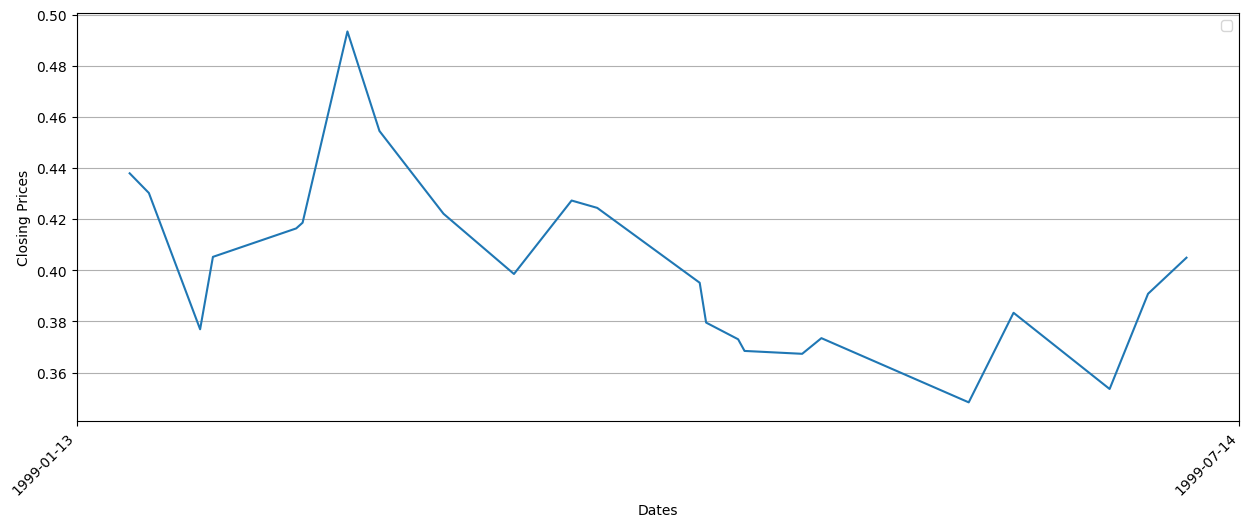

break


In [49]:
for x in range(0, 2000):
    try:
        print("Showing live each 5 seconds:")
        kafkaDf = spark.read.format("kafka").option("kafka.bootstrap.servers", kafka_server).option("subscribe", topic_name).option("startingOffsets", "earliest").load()
        df = kafkaDf.selectExpr("CAST(value AS STRING)").select(split("value", ",").alias("csv_values")) \
            .selectExpr("csv_values[0] as Date", "csv_values[1] as Close")
        df1 = df
        df1 = kafkaDf.withColumn("csv_values", split("value", ",")) \
            .withColumn("Date_e", col("csv_values")[0]) \
            .withColumn("Close_e", col("csv_values")[1]) \
            .withColumn("Date", split("Date_e", ":")[1]) \
            .withColumn("Close", split("Close_e", ":")[1]) \
            .selectExpr("CAST(Date AS STRING)", "CAST(Close AS STRING)") \
            .withColumn("Date", regexp_replace("Date", '"', "")) \
            .withColumn("Close", regexp_replace("Close", "}", "")) \
            .withColumn("Date", regexp_replace("Date", ' ', "")) \
            .withColumn("Close", regexp_replace("Close", " ", "")) \
            .withColumn("Date", to_date("Date", "yyyy-MM-dd")) \
            .withColumn("Close", col("Close").cast(DoubleType()))
        pandas_df = df1.toPandas()
        pandas_df['Date'] = pd.to_datetime(pandas_df['Date'])
        pandas_df.set_index('Date', inplace=True)
        #Vẽ biểu đồ thể hiện sự biến đổi giá cổ phiếu qua các năm.
        plt.figure(figsize=(15,6))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=600))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        x_dates = [dt.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d').date() for d in pandas_df.index.to_pydatetime()]

        plt.plot(x_dates, pandas_df['Close'])
        plt.xlabel('Dates')
        plt.ylabel('Closing Prices')
        plt.legend()
        plt.gcf().autofmt_xdate()
        plt.xticks(rotation = 45)
        plt.grid(True)
        plt.show()
        sleep(5)
        clear_output(wait=True)
    except KeyboardInterrupt:
        print("break")
        break